# Classification supervisée de texte 

L'objectif est d'étudier et expérimenter une technique simple permettant de classer automatique un nouveau texte parmi des catégories thématiques. Ces catégories auront été construites par un apprentissage supervisé, selon une technique proche de ce qui aura été vu pour la classification d'image.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # librairie de visualisation de données

## observation des corpus de textes d'apprentissage et de test

* Charger le corpus 20Newsgroups, un corpus classique de textes fourni dans la librairie python scikit-learn
* Il est constitué de quelques milliers de "posts" publiés dans 20 forums thématiques différents.
* C'est le forum thématique dans lequel le post a été publié qui constitue la "vérité" thématique d'un post.
* Un intérêt du corpus est que certains thèmes sont proches les uns des autres, d'autres sont plus éloignés


In [2]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()

#  affichage des noms des 20 sous-corpus de ce corpus 
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

On choisit maintenant à la main un sous-ensemble de ces catégories. Vous êtes encouragés à modifier les catégories et à en changer le nombre

In [58]:
categories_choisies = ['sci.med', 'rec.autos','comp.sys.mac.hardware',
              'rec.motorcycles', 'rec.sport.baseball','rec.sport.hockey']

On va maintenant constituer des jeux d'apprentissage et de test sur ce corpus. L'affectation des textes à l'apprentissage ou au test est prédéfinie dans la librairie logicielle et dépend de la date à laquelle le texte avait été posté sur le forum de discussion. On affiche le nombre de textes pour apprentissage et test, puis un exemple de texte. 

In [59]:
train = fetch_20newsgroups(subset='train', categories=categories_choisies)
test = fetch_20newsgroups(subset='test', categories=categories_choisies)
print(len(train.data))
print(len(test.data))
print(train.data[10])

3561
2371
From: tcora@pica.army.mil (Tom Coradeschi)
Subject: Re: "Beer" unto bicyclists
Organization: Elect Armts Div, US Army Armt RDE Ctr, Picatinny Arsenal, NJ
Lines: 23
Nntp-Posting-Host: b329-gator-3.pica.army.mil

In article <31MAR199308594057@erich.triumf.ca>, ivan@erich.triumf.ca (Ivan
D. Reid) wrote:
> 
> In article <tcora-250393111517@b329-gator-1.pica.army.mil>,
> 	 tcora@pica.army.mil (Tom Coradeschi) writes...
> >mxcrew@PROBLEM_WITH_INEWS_DOMAIN_FILE (The MX-Crew) wrote:
> >> just an information (no flame war please): Budweiser is a beer from the
> >> old CSFR (nowadays ?Tschechien? [i just know the german word]).
> 
> >Czechoslovakia. Budweiser Budwar (pronounced bud-var).
>  ^^^^^^^^^^^^^^
> 	Not any more, a short while ago (Jan 1st?) it split into The Czech
> Republic and Slovakia.  Actually, I think for a couple of years its official
> name was "The Czech and Slovak Republics".  Sheesh!  Don't you guys get CNN??

CNN=YuppieTV

                  tom coradeschi <+> tcor

Regardons, par curiosité, les indicateurs de classe des premiers textes du sous-ensemble servant à l'apprentissage. Les catégories thématiques sont-elles rangées dans un ordre particulier ?

In [60]:
print(train.target[:30])

[5 4 3 4 5 2 0 3 1 4 2 5 4 1 4 5 0 3 2 1 4 0 0 5 0 5 3 0 4 5]


## Vectorisation des textes et caractérisation des catégories thématiques par des distributions multinomiales

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [62]:
train = fetch_20newsgroups(subset='train', categories=categories_choisies, remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', categories=categories_choisies, remove=('headers', 'footers', 'quotes'))


### Petite observation préalable de la vectorisation d'un texte

Ici, on va transformer en vecteur numérique chaque texte du corpus. Cela passe par la construction, à partir de ce corpus, d'une liste de termes qui y sont présents, et de l'exfiltrage d'un certain nombre de ces termes, sous l'hypothèse (basées sur des résultats de recherche dans le domaine) qu'ils ne sont pas très utiles pour la classification thématique du texte. Le principe général est de décrire un texte comme le nombre de fois (nombre d'occurrences) de chaque mot du vocabulaire dans le texte. Le vocabulaire est l'ensemble des mots préalablement recensés dans le corpus. On réalise que cette manière de décrire un texte fait le choix d'ignorer l'ordre des mots dans le texte, ce qui fait perdre de l'information mais simplifie beaucoup la tâche. L'expérience montre que des bons résultats peuvent être obtenus malgré cette simplification. Cette représentation s'appelle "sacs de mots".

In [63]:

vectorizer = TfidfVectorizer(max_df=0.7, min_df=10, stop_words='english' )

# ci-dessus, df : document frequency
# où on supprime les termes plus fréquents que max_df sur le corpus entier (pas par sous-corpus)
# où on supprime les termes plus rares (nb d'occurences que min_df)

matrice_termes_documents = vectorizer.fit_transform(train.data)

Afficher les dimensions de la matrice et son contenu (on obtient les dimensions avec nom_de_la_matrice.shape). Observer la représentation informatique choisie pour la matrice et tenter de comprendre ce choix. 

Vocabulaire qui a été extrait s'affiche ci-dessous. Attention à bien faire défiler suffisamment pour trouver les mots (il n'y pas eu de nettoyager pour supprimer les autres mots que ceux composés de caractèes alphabétiques) ! Retrouve t-on le même terme au pluriel et au singulier ? Le même verbe conjugué à diverses personnes ou divers temps ? Si oui, sachez que d'autres librairies python permettent de trouver la racine d'un mot (librairie NTLK par exemple).

In [64]:
print(vectorizer.get_feature_names())

['00', '000', '01', '02', '03', '030', '04', '040', '05', '06', '07', '08', '09', '10', '100', '1000', '101', '102', '103', '104', '105', '106', '1069', '108', '109', '11', '110', '112', '113', '114', '116', '117', '118', '119', '12', '120', '121', '123', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '135', '14', '140', '141', '143', '144', '145', '149', '15', '150', '155', '16', '160', '161', '17', '170', '175', '176', '18', '180', '185', '19', '190', '1958', '1968', '1972', '1976', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '199', '1990', '1991', '1992', '1993', '1a', '1b', '1st', '20', '200', '2000', '202', '205', '206', '20th', '21', '210', '213', '214', '219', '22', '222', '225', '23', '230', '235', '24', '240', '25', '250', '253', '256', '26', '268', '27', '28', '280', '286', '29', '2b', '2nd', '30', '300', '3000', '301', '31', '312', '32', '320', '33', '34', '35', '350', '36', '37', '38', '386', '39', '3b', '3rd', '40',

### Estimation de la distribution de probabilité sur le vocabulaire par classe

In [65]:
model = make_pipeline(TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english'), MultinomialNB()) #
model.fit(train.data, train.target)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english')),
                ('multinomialnb', MultinomialNB())])


Utilisons le théorème de Bayes pour exprimer la probabilité d'un thème en fonction des mots observés dans un texte à classer. Dans le cas d'un vocabulaire à 2 mots (en réalité, on en a des centaines, ici c'est pour simplifier l'explication) : 

$$p(theme|mot1,mot2)=\frac{\mathbf{p((mot1,mot2)|theme)}\quad p(theme)}{p(mot1,mot2)} \quad \text{(Bayes)}$$

Simplifions maintenant cette expression en faisant l'approximation de $p((mot1,mot2)|theme)$ par $p(mot1|theme)p(mot2|theme)$. Cette approximation est connue sous le nom de "Bayes naïf".

$$p(theme|mot1,mot2)=\frac{\mathbf{p(mot1|theme)p(mot2|theme)}\quad p(theme)}{p(mot1,mot2)}  \quad \text{(Naive Bayes)}$$ 

Cela a permis de faire apparaître les termes $p(mot1|theme)$ et $ p(mot2|theme)$ qui montrent qu'une tâche principale va être d'estimer la distribution de probabilité des mots, pour un thème donné. Cette distribution peut se construire à partir du corpus, dans le cadre d'un apprentissage supervisé.

Une première approche consiste à calculer un histogramme (fréquence d'occurence de chaque mot du vocabulaire) et le normaliser pour en faire une distribution de probabilité. Cette approche est globalement la bonne direction, mais elle mérite d'être immédiatement améliorée car elle souffre du problème rapidement fatal suivant. Supposer que le texte à classer contient le mot mot1, qui n'est pas présent dans le corpus du theme1. Alors on estime $p(mot1|theme)=0$ et automatiquement cela entraine $p(theme|mot1,mot2)=0$. Autrement dit, il suffit qu'un seul des mots du texte à classer soit absent du corpus d'un thème pour invalider la moindre possibilité que ce texte soit à associer à ce thème. Cette exclusion est trop radicale.

Le problème ci-dessus est à rapprocher du scenario suivant, où on ne raisonne que par intuition : soit un dé à 6 faces dont on ne connait pas les 6 probabilités de sortir. On le lance 10 fois. Si on n'obtient aucune fois la face 2, va t-on pour autant conclure que la face 2 a une probabilité nulle (d'arriver à l'avenir) ? Probablement pas : on préferera conclure que la face 2 a une probabilité faible mais on souhaitera aussi considérer qu'elle ne soit jamais sortie relève aussi du caractère aléatoire des lancers. C'est ce qu'on souhaitera aussi penser pour le mot1 qui n'est jamais sorti dans le corpus d'apprentissage d'un thème : on ne souhaite pas complètement exclure qu'il puisse être présent dans d'autres textes à rattacher à ce thème. Si, dans cette histoire, on remplace 10 lancers par 1000 lancers, on voudrait estimer à très faible (mais toujours non nulle) la probabilité de tirer un 2 à l'avenir.

Une manière propre et mathématique (et donc informatique) de formaliser le paragraphe précédent est d'estimer la distribution de probabilité associée à un thème de manière un peu plus sophistiquée que simplement l'assimiler à l'histogramme des fréquences observées. Plus précisément, on va considérer que l'histogramme des fréquences de mots observé sur un corpus rattaché à un thème est la réalisation issue d'un tirage aléatoire d'une loi de probabilité multinomiale. Une loi multinomiale est l'extension à plus de 2 faces de la loi binomiale bien connue pour les pièces : 6 faces pour un dé, des centaines de faces pour un vocabulaire en classification de texte. Dans le cas à 2 faces, il y a 1 paramètre : la probabilité de tirer "pile", qui contraint la probabilité de tirer "face" à être 1-probabilité de tirer pile. De manière analogue, dans le cas d'un dé à 6 faces, il y aura 5 paramètres libres. Pour traiter efficacement le sujet de la dépendance à l'échantillon particulier, l'estimation des paramètres de cette loi multinomiale gagne alors à se faire par une estimation dite bayesienne. Partant de la croyance a priori que tous les mots arrivent de manière équiprobable, on révise pour chacun des mots la croyance (c.a.d. le paramètre, assimilable à une probabilité) à la hausse ou à la baisse au fur et à mesure que les tirages (les observations) nous donnent des indices en ce sens. Dans le cas d'une distribution multinomiale, cette opération se fait avec une distribution de Dirichlet, qui est une distribution de probabilité sur les paramètres d'une loi multinomiale. Ainsi, plutôt que de qualifier la probabilité de la face 2 d'arriver par un seul chiffre, on associe une distribution de probabilité à cette face et ainsi l'information d'incertitude est représentée et manipulée de manière plus riche. Plutôt que de poursuivre la discussion sur ce cadre puissant, pour notre application des calculs montrent qu'il existe une déclinaison mathématique très simple de cette démarche : pour chaque mot du vocabulaire, on ajoute une occurence fictive dans le corpus et on estime la distribution multinomiale comme l'histogramme qui en résulte. Ainsi, pour un thème donné, si on a un vocabulaire à 3 mots donc les fréquences observées sont 3,0 et 7, au lieu d'une distribution [3/10,0/10,7/10] on utilise [4/13,1/13,8/13]. Ainsi, on préserve une probabilité faible plutôt que nulle pour les termes qui ne sont jamais arrivés. L'évocation ci-dessous de l'estimation bayesienne avec la distribution de Dirichlet vise à souligner que l'ajout d'une occurence fictive n'est pas qu'un bricolage mais trouve une explication mathématique propre pour qui veut la creuser.

Pour une version plus détaillée de la même histoire (facultatif mais intéressant), on pourra se référer à https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb  

En pratique, la librairie logicielle utilisée dans ce TP utilise cette occurence fictive ($\alpha=1$ par défaut). https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

Par ailleurs, dans 
$$p(theme|mot1,mot2)=\frac{\mathbf{p(mot1|theme)p(mot2|theme)}\quad p(theme)}{p(mot1,mot2)}  \quad \text{(Naive Bayes)}$$, 
* $p(theme)$, en l'absence d'autre information, peut être choisie comme uniforme, c'est à dire =1/(nombre de thèmes)
* le dénominateur peut se calculer en décomposant/sommant sur l'ensemble des thèmes, c.a.d. en calculant les numérateurs pour tous les thèmes et en normalisant pour que la somme fasse 1.

### Utilisation de ces modèles pour classer les données de test

Pour chaque texte du corpus de test, on détermine quel est le thème le plus probable, avec la démarche de Bayes naïf décrire ci-dessus. `labels` contient le thème identifié comme le plus probable pour chacun des 2358 textes, qu'on va ensuite confronter avec la véritable classe, c.a.d. le forum thématique d'où est issu le texte.

In [66]:
labels = model.predict(test.data) 

### Analyse des résultats par matrice de confusion

A faire : évaluer globalement la qualité des résultats de classification, localiser les erreurs majeures, si possible essayer d'en deviner les causes, faire l'expérience avec des corpus différents (des sous-corpus thématiques plus ou moins faciles à confondre). Réponse à faire sur madoc.

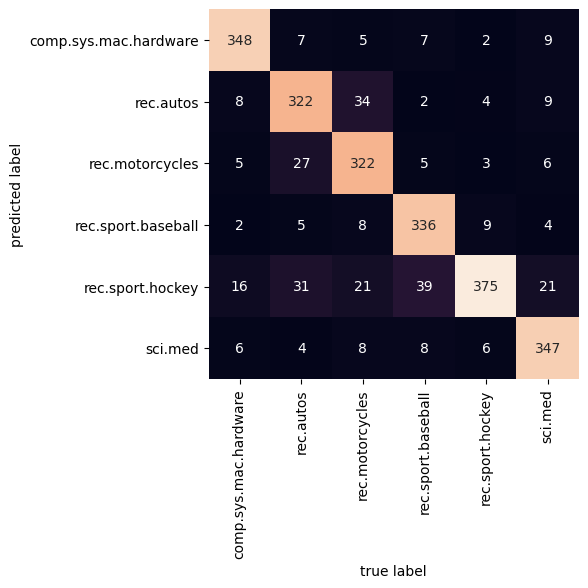

In [67]:
from sklearn.metrics import confusion_matrix


# Calcul de la matrice de confusion
mat = confusion_matrix(test.target, labels)

# Affichage de la matrice de confusion
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Classification d'un nouveau texte 

Ici, on entre une phrase en texte libre et la probabilité que cette phrase relève d'un thème est calculée, pour chaque thème. A vous d'imaginer un jeu d'essais pour évaluer qualitativement la performance et identifier les limites. Réponse à faire sur madoc.

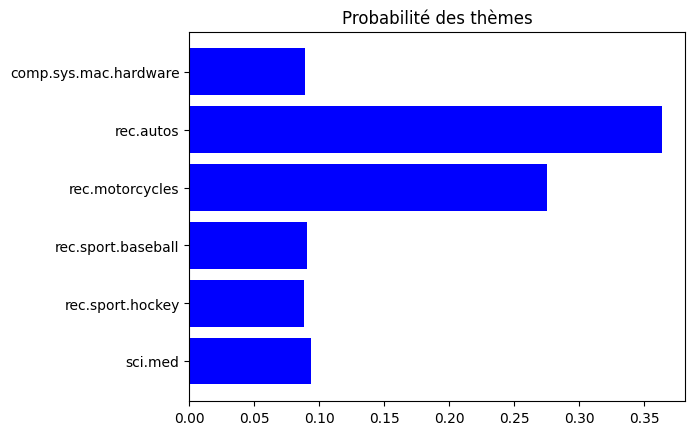

In [74]:

probability_vector = model.predict_proba(['vehicle'])


import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(train.target_names))

ax.barh(y_pos, probability_vector[0,:], align='center',
        color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(train.target_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Probabilité des thèmes')

plt.show()